# Exponential Smoothing

Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

## Simple Exponential Smoothing (SES)

This method is suitable for forecasting data with no clear trend or seasonal pattern.

The component form of the SES is represented as:

Forecast equation: $\hat{y}_{t+h|t} = l_{t} $

Smoothing equation: $l_{t} = \alpha y_{t} + (1 - \alpha)l_{t-1}$

Where $\hat{y}_{t+h|t}$ is the predicted value at time $t+h$ due $t$, $l_{t}$ is the smoothed value of the series at time $t$ and $\alpha$ is the smoothing parameter. The initial smoothed value is represented as $l_{0}$.

To solve the smoothing equation we only need to apply the recurrence equation all the times needed, knowing the parameters: $\alpha$ and $l_{0}$.

The next example imports a time series data from the R-package 'fpp2'. The time series represents the Annual oil production (millions of tonnes), Saudi Arabia, 1965-2013 (Forecasting: Principles and Practice).

In [3]:
!pip install tscv

In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tscv
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from tscv import GapWalkForward
from rpy2.robjects import pandas2ri, r
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
# install fpp2 package
utils = importr('utils')
utils.install_packages('fpp2')

In [6]:
# load fpp2 package
ro.r('library(fpp2)')

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: forecast

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Loading required package: fma

R[write to console]: Loading required package: expsmooth



array(['fpp2', 'expsmooth', 'fma', 'forecast', 'ggplot2', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

In [0]:
# get the data
oil_np = r('oil')

In [0]:
# create the years
date_list = [datetime(year=i, month=1, day=1) for i in range(1965,2014)]
oil_df = pd.DataFrame(oil_np, index=date_list)
oil_df.columns = ['production']
oil_df = oil_df.loc[datetime(year=1996, month=1, day=1):datetime(year=2013, month=1, day=1),:]

To reproduce the exercise, we only consider the dates from year 1996.

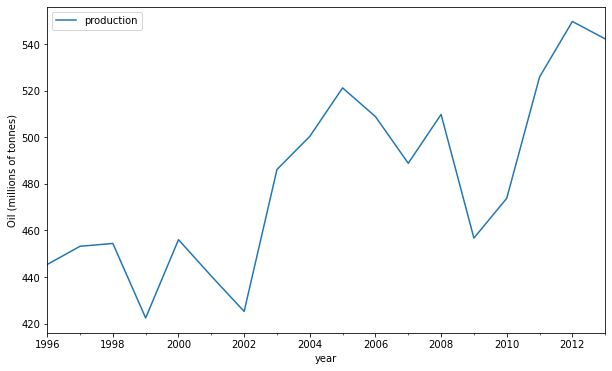

In [9]:
oil_df.plot(figsize=(10,6))
plt.xlabel('year')
plt.ylabel('Oil (millions of tonnes)')
plt.show()



The next code will solve the problem for the oil time series including the selection of parmameters $\alpha$ and $l_{0}$.


In [0]:
model = SimpleExpSmoothing(np.asarray(oil_df['production']))
model._index = oil_df.index
model_fit_ses = model.fit()

In [11]:
print('The initial smoothed value estimated is: ', round(model_fit_ses.params['initial_level'], 2))
print('The smoothing level estimated is: ', round(model_fit_ses.params['smoothing_level'], 2))

The initial smoothed value estimated is:  446.58
The smoothing level estimated is:  0.83


The next table shows the result of the fitting process:

In [12]:
ses_df = pd.DataFrame(np.zeros((18,4)), columns=['time', 'observation', 'level', 'forecast'])
ses_df.level = model_fit_ses.level
ses_df.observation = oil_df.production.values
ses_df.time = model._index
ses_df.forecast = model_fit_ses.fittedfcast[:-1]
ses_df.set_index('time', drop=True, inplace=True)
ses_df

,observation,level,forecast
time,,,
1996-01-01,445.364098,445.565403,446.575626
1997-01-01,453.195010,451.927293,445.565403
1998-01-01,454.409641,453.997180,451.927293
1999-01-01,422.378906,427.632521,453.997180
2000-01-01,456.037122,451.317482,427.632521
2001-01-01,440.386605,442.202853,451.317482
2002-01-01,425.194373,428.020460,442.202853
2003-01-01,486.205174,476.537343,428.020460
2004-01-01,500.429086,496.459292,476.537343


To predict oil production values of 5 years ahead we use the function predict.

In [13]:
observations_num = oil_df.shape[0]
predict = model_fit_ses.predict(observations_num, observations_num+4)
predict

array([542.68035439, 542.68035439, 542.68035439, 542.68035439,
       542.68035439])

We get the same number because, in the SES technique, all forecasts take the same value, equal to the last level component.

Next plot shows the observations and one-step-ahead forecast. The green line shows the forecast for 5 years ahead.

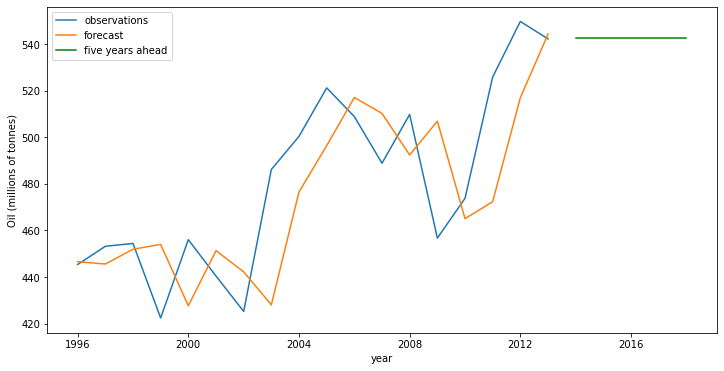

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ses_df.index, ses_df.observation.values, label='observations')
ax.plot(ses_df.index, ses_df.forecast.values, label='forecast')
ax.plot([datetime(year=i, month=1, day=1) for i in range(2014,2019)], predict, color="green", label='five years ahead')  
plt.xlabel('year')
plt.ylabel('Oil (millions of tonnes)')
plt.legend()
plt.show()

In [15]:
print('The sum of the squared errors is: ', round(model_fit_ses.sse))

The sum of the squared errors is:  14236.0


## Holt’s linear trend method

Holt (1957) extended simple exponential smoothing to allow the forecasting of data with a trend.

Forecast equation: $\hat{y}_{t+h|t} = l_{t} + hb_{t}$

Level equation: $l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1}+b_{t-1})$

Trend equation: $b_{t} = \beta^* (l_{t}-l_{t-1}) + (1 - \beta^*)b_{t-1}$

Where $b_{t}$ denotes an estimate of the trend, $\beta^*$ is the smoothing parameter for the trend

To run the example we need to load the total annual air passengers (in millions) including domestic and international aircraft passengers of air carriers registered in Australia (1970-2016). To reproduce the exercise, we only consider the dates from year 1990.

In [0]:
# get the data
air_np = r('ausair')

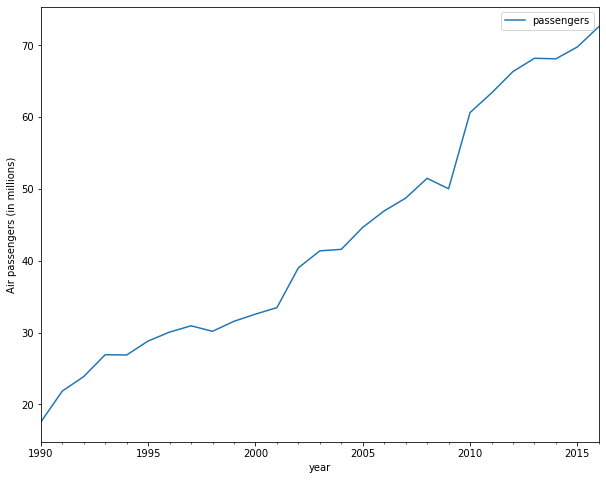

In [17]:
# create the years
date_list = [datetime(year=i, month=1, day=1) for i in range(1970,2017)]
air_df = pd.DataFrame(air_np, index=date_list)
air_df.columns = ['passengers']
air_df = air_df.loc[datetime(year=1990, month=1, day=1):datetime(year=2016, month=1, day=1),:]

# plot data
air_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Air passengers (in millions)')
plt.show()

In [0]:
model = Holt(np.asarray(air_df['passengers']))
model._index = air_df.index
model_fit_holt = model.fit()

In [19]:
print('The initial smoothed value estimated is: ', round(model_fit_holt.params['initial_level'], 2))
print('The smoothing level estimated is: ', round(model_fit_holt.params['smoothing_level'], 2))
print('The initial slope value estimated is: ', round(model_fit_holt.params['initial_slope'], 2))
print('The smoothing slope estimated is: ', round(model_fit_holt.params['smoothing_slope'], 2))

The initial smoothed value estimated is:  15.85
The smoothing level estimated is:  0.82
The initial slope value estimated is:  2.1
The smoothing slope estimated is:  0.0


In [20]:
holt_df = pd.DataFrame(np.zeros((27,5)), columns=['time', 'observation', 'level', 'slope', 'forecast'])
holt_df.level = model_fit_holt.level
holt_df.observation = air_df.passengers.values
holt_df.time = model._index
holt_df.forecast = model_fit_holt.fittedfcast[:-1]
holt_df.slope = model_fit_holt.slope
holt_df.set_index('time', drop=True, inplace=True)
holt_df

,observation,level,slope,forecast
time,,,,
1990-01-01,17.553400,17.624299,2.097918,17.949565
1991-01-01,21.860100,21.477496,2.097918,19.722217
1992-01-01,23.886600,23.830909,2.097918,23.575414
1993-01-01,26.929300,26.750251,2.097918,25.928827
1994-01-01,26.888500,27.239210,2.097918,28.848169
1995-01-01,28.831400,28.921907,2.097918,29.337128
1996-01-01,30.075100,30.244172,2.097918,31.019825
1997-01-01,30.953500,31.202008,2.097918,32.342089
1998-01-01,30.185700,30.743034,2.097918,33.299925


We predict 5 years ahead and plot all results.

In [0]:
observations_num = air_df.shape[0]
predict_holt = model_fit_holt.predict(observations_num, observations_num+4)

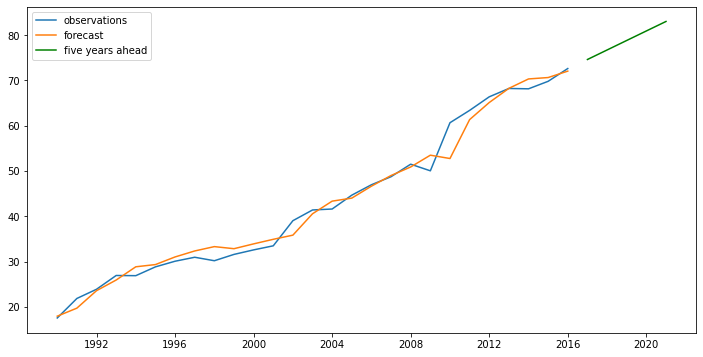

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(holt_df.index, holt_df.observation.values, label='observations')
ax.plot(holt_df.index, holt_df.forecast.values, label='forecast')
ax.plot([datetime(year=i, month=1, day=1) for i in range(2017,2022)], predict_holt, color="green", label='five years ahead')  
plt.legend();

## Damped trend methods

The forecasts generated by Holt’s linear method display a constant trend indefinitely into the future. Empirical evidence indicates that these methods tend to over-forecast, especially for longer forecast horizons. Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some time in the future. Methods that include a damped trend have proven to be very successful.

Forecast equation: $\hat{y}_{t+h|t} = l_{t} + (\phi + \phi^2 + ...+\phi^h)b_{t}$

Level equation: $l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1}+\phi b_{t-1})$

Trend equation: $b_{t} = \beta^* (l_{t}-l_{t-1}) + (1 - \beta^*)\phi b_{t-1}$

If $\phi=1$, the method is identical to Holt’s linear method. For values between 0 and 1, $\phi$ dampens the trend so that it approaches a constant some time in the future. This means that short-run forecasts are trended while long-run forecasts are constant.

We apply this variant to the Air Passengers forecast.

In [0]:
model = Holt(np.asarray(air_df['passengers']), damped=True)
model._index = air_df.index
model_fit_damp = model.fit(damping_slope=0.9)

In [0]:
# predict 15 years ahead with both variants of Holt

observations_num = air_df.shape[0]
predict_holt = model_fit_holt.predict(observations_num, observations_num+14)
predict_holt_damped = model_fit_damp.predict(observations_num, observations_num+14)

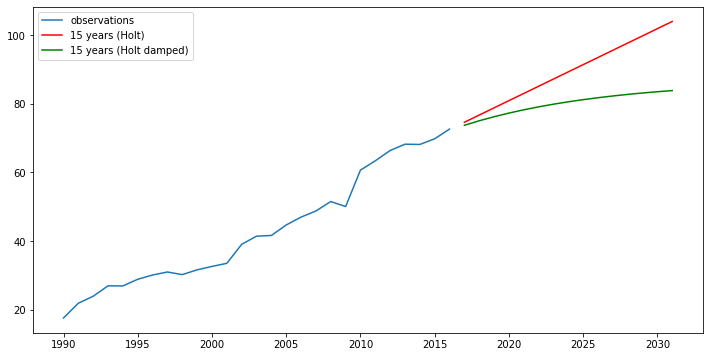

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(holt_df.index, air_df.passengers.values, label='observations')
ax.plot([datetime(year=i, month=1, day=1) for i in range(2017,2032)], predict_holt, color="red", label='15 years (Holt)')  
ax.plot([datetime(year=i, month=1, day=1) for i in range(2017,2032)], predict_holt_damped, color="green", label='15 years (Holt damped)')  
plt.legend();

We have set the damping parameter but, usually, we would estimate $\phi$ along with the other parameters.

## Select the model using cross-validation

We compare the forecasting performance of the three exponential smoothing methods that we have considered in forecasting the sheep livestock population in Asia. The data spans the period 1961–2007.

We use cross-validation, implemented in the next function, to select the best method. In the first fold, the model is fitted within the first two observations ($t_1, t_2$) and it forcasts the third one ($t_3$). The second fold fits the model using $t_1, t_2, t_3$ and it forecasts $t_4$, and so on.

In [0]:
# time series cross-validation

def timeseriesCVscore(series, tscv, create_model, fit_model):
    """
    Computes the forecast error on CV
    :param series: time series data
    :param tscv: cross-validation function
    :param create_model: function to create the forecast model
    :param fit_model: function to fit the model
    :return: the errors in the predictions
    """

    errors = [] 
    values = series.values
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(range(len(values))):
      model = create_model(values[train])
      model_fitted = fit_model(model)
      predictions = model_fitted.predict(test[0], test[-1])
      actual = values[test]
      error = actual-predictions
      errors.append(error)
        
    return errors

We get the data and visualize the time series.

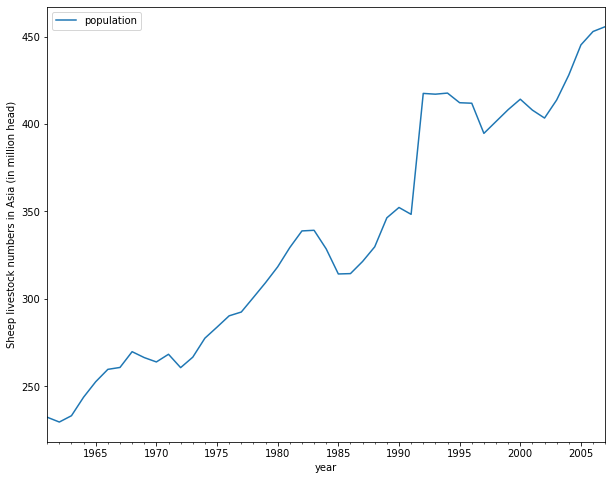

In [27]:
# get the data
sheep_np = r('livestock')

# create the years
index= pd.date_range(start='1961', end='2008', freq='A')
sheep_df = pd.DataFrame(sheep_np, index)
sheep_df.columns = ['population']

# plot data
sheep_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Sheep livestock numbers in Asia (in million head)')
plt.show()

In [0]:
# set parameters

series = sheep_df.population
tscv = GapWalkForward(n_splits=len(series)-2, gap_size=0, test_size=1)

# Simple Exponential Smoothing
def ses_model(ts):
  return SimpleExpSmoothing(ts)

# Holt
def holt_model(ts):
  return Holt(ts)

# Holt damped
def holt_damped_model(ts):
  return Holt(ts, damped=True)

def model_fit(m):
  return m.fit()

e_ses = timeseriesCVscore(series, tscv, create_model=ses_model, fit_model=model_fit)
e_ses = np.asarray(e_ses).flatten()

e_holt = timeseriesCVscore(series, tscv, create_model=holt_model, fit_model=model_fit)
e_holt = np.asarray(e_holt).flatten()

e_holt_damped = timeseriesCVscore(series, tscv, create_model=holt_damped_model, fit_model=model_fit)
e_holt_damped = np.asarray(e_holt_damped).flatten()

In [29]:
# computing mean square error

print(np.mean(e_ses**2))
print(np.mean(e_holt**2))
print(np.mean(e_holt_damped**2))

175.00538634959983
183.0975314599943
188.79084581166364


In [30]:
# computing mean absolute error

print(np.mean(np.abs(e_ses)))
print(np.mean(np.abs(e_holt)))
print(np.mean(np.abs(e_holt_damped)))

8.438178830496138
8.467854440169392
8.86815172400456


Attending to the results, the best method is SES. Unfortunately, that result is not accurate according to the original source (Forecasting: Principles and Practice). The optimization mechanism is not working as expected. To prove this, we call the R code to show the results using that implementation.

In [0]:
# call R function tsCV

e1 = ro.r('e1 <- tsCV(livestock, ses, h=1)')
e2 = ro.r('e2 <- tsCV(livestock, holt, h=1)')
e3 = ro.r('e3 <- tsCV(livestock, holt, damped=TRUE, h=1)')

In [32]:
# remove some nan values
e1 = e1[~np.isnan(e1)]
e2 = e2[~np.isnan(e2)]
e3 = e3[~np.isnan(e3)]

# computing mean square error
print(np.nanmean(e1**2))
print(np.nanmean(e2**2))
print(np.nanmean(e3**2))

178.2531131728796
173.3649854138271
162.62743440765902


The best method reported is damped Holt's method. We take this as the winner and proceed with the forecast.

In [33]:
# fit the method to data
ro.r('fc <- holt(livestock, damped=TRUE, h=10)')
ro.r('model <- fc[["model"]]')

# show the parameters
ro.r('print(model)')
ro.r('print(model$par)')

# save the parameters
alpha = ro.r('model$par[1]')[0]
beta = ro.r('model$par[2]')[0]
phi = ro.r('model$par[3]')[0]
l0 = ro.r('model$par[4]')[0]
b0 = ro.r('model$par[5]')[0]

Damped Holt's method 

Call:
 holt(y = livestock, h = 10, damped = TRUE) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 3e-04 
    phi   = 0.9798 

  Initial states:
    l = 223.35 
    b = 6.9046 

  sigma:  12.8435

     AIC     AICc      BIC 
427.6370 429.7370 438.7379 
       alpha         beta          phi            l            b 
9.998998e-01 2.806460e-04 9.797542e-01 2.233500e+02 6.904597e+00 


The smoothing parameter for the slope is estimated to be essentially zero, indicating that the trend is not changing over time. The value of $\alpha$ is very close to one, showing that the level reacts strongly to each new observation.

In [0]:
# train model in python with the parameters estimated in R

model = Holt(np.asarray(sheep_df['population']), damped=True)
model_fit_damp = model.fit(smoothing_level=alpha, smoothing_slope=beta, damping_slope=phi, initial_level=l0, initial_slope=b0, optimized=False)
predict_holt_damped = model_fit_damp.forecast(10)

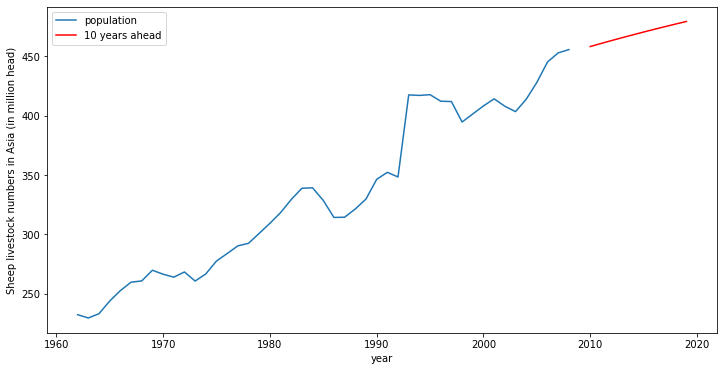

In [53]:
# show the forecasting

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(sheep_df.index, sheep_df.population.values, label='population')
ax.plot(pd.date_range(start='2009', end='2019', freq='A'), predict_holt_damped, color="red", label='10 years ahead')
plt.xlabel('year')
plt.ylabel('Sheep livestock numbers in Asia (in million head)')  
plt.legend();

## Holt-Winters’ seasonal method

Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations with corresponding smoothing parameters $\alpha$, $\beta^*$ and $\gamma$. There are two variations to this method that differ in the nature of the seasonal component: the additive and the multiplicative.

We apply Holt-Winters’ method with both additive and multiplicative seasonality to forecast quarterly visitor nights in Australia spent by international tourists.

In [0]:
# get the data
tour_np = r('austourists')

In [0]:
# create the years
index= pd.date_range(start='1999', end='2016', freq='Q')
tour_df = pd.DataFrame(tour_np, index)
tour_df.columns = ['nights']
tour_df = tour_df.loc[datetime(year=2005, month=3, day=31):,:]

hw_add_model = ExponentialSmoothing( tour_df.nights.values, trend='additive',
                                       damped=False, seasonal='additive',
                                       seasonal_periods=4)
hw_add_fit = hw_add_model.fit()

hw_mul_model = ExponentialSmoothing( tour_df.nights.values, trend='additive',
                                       damped=False, seasonal='multiplicative',
                                       seasonal_periods=4)
hw_mul_fit = hw_mul_model.fit()

In [38]:
hw_add_fit.summary()

Dep. Variable:,endog,No. Observations:,44
Model:,ExponentialSmoothing,SSE,135.921
Optimized:,True,AIC,65.627
Trend:,Additive,BIC,79.900
Seasonal:,Additive,AICC,72.293
Seasonal Periods:,4,Date:,"Tue, 26 May 2020"
Box-Cox:,False,Time:,07:42:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2622038,alpha,True
smoothing_slope,1.9007e-12,beta,True


In [39]:
hw_mul_fit.summary()

Dep. Variable:,endog,No. Observations:,44
Model:,ExponentialSmoothing,SSE,105.175
Optimized:,True,AIC,54.343
Trend:,Additive,BIC,68.617
Seasonal:,Multiplicative,AICC,61.010
Seasonal Periods:,4,Date:,"Tue, 26 May 2020"
Box-Cox:,False,Time:,07:42:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3639333,alpha,True
smoothing_slope,1.0105e-19,beta,True


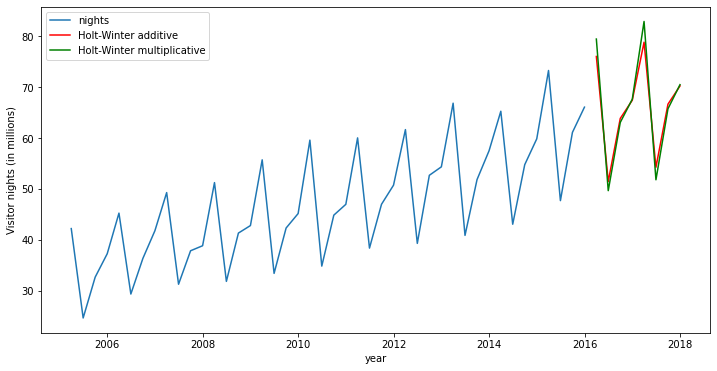

In [54]:
# show the forecasting

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tour_df.index, tour_df.nights.values, label='nights')
ax.plot(pd.date_range(start='2016', end='2018', freq='Q'), hw_add_fit.forecast(8), color="red", label='Holt-Winter additive')
ax.plot(pd.date_range(start='2016', end='2018', freq='Q'), hw_mul_fit.forecast(8), color="green", label='Holt-Winter multiplicative') 
plt.xlabel('year')
plt.ylabel('Visitor nights (in millions)')
plt.legend();

According to the SSE computed over the residuals, the multiplicative variant is more accurate with SSE=105. The additive has SSE=135.

## Prediction intervals

Some times is useful to know the probability associated with the forecast. The function ets, from the _forecast_ R-package, provides such a possibility.

We test it with the 'austourists' data, starting by year 2005. If no parameters are especified, the function search the model by minimising the Corrected Akaike’s Information Criterion (AICc). 

In [107]:
# find a proper model for the data

ro.r('aust <- window(austourists, start=2005)')
ro.r('fit <- ets(aust)')
ro.r('summary(fit)')

ETS(M,A,M) 

Call:
 ets(y = aust) 

  Smoothing parameters:
    alpha = 0.1908 
    beta  = 0.0392 
    gamma = 2e-04 

  Initial states:
    l = 32.3679 
    b = 0.9281 
    s = 1.0218 0.9628 0.7683 1.2471

  sigma:  0.0383

     AIC     AICc      BIC 
224.8628 230.1569 240.9205 

Training set error measures:
                     ME     RMSE     MAE        MPE     MAPE     MASE      ACF1
Training set 0.04836907 1.670893 1.24954 -0.1845609 2.692849 0.409454 0.2005962


array([[ 0.04836907,  1.6708929 ,  1.24953967, -0.18456085,  2.69284872,
         0.40945405,  0.2005962 ]])

The model selected is the variant with multiplicative errors, additive trend and multiplicative seasonality (MAM).

In [0]:
# forecast 8 quarters in the future

ro.r('ets_predict <- forecast(fit, h=8)')
upper = ro.r('ets_predict$upper')
lower = ro.r('ets_predict$lower')
ets_forecast = ro.r('ets_predict$mean')

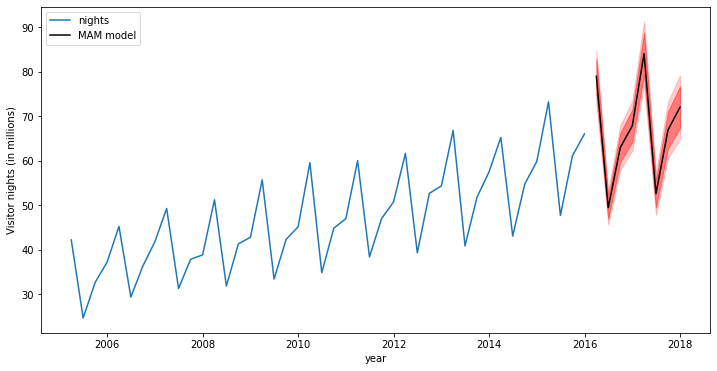

In [106]:
# show the forecasting and confidence intervals

index = pd.date_range(start='2016', end='2018', freq='Q')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tour_df.index, tour_df.nights.values, label='nights')
ax.fill_between(index, upper[:,1], lower[:,1], color='red', alpha=0.2);
ax.fill_between(index, upper[:,0], lower[:,0], color='red', alpha=0.4);
ax.plot(index, ets_forecast, color="black", label='MAM model')
plt.xlabel('year')
plt.ylabel('Visitor nights (in millions)')
plt.legend(loc='upper left');

The red area represents the 80% prediction interval for the future values and the light red area represents 95%.